In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os 
import re
from scipy.optimize import curve_fit


In [ ]:
# 1. Define the power-law model for curve_fit
def power_law(t, A, alpha):
    """A power-law model: A * t^alpha."""
    return A * np.power(t, alpha)

# 2. Create a helper function to perform the fit on a single MSD curve
def fit_msd_and_get_alpha(msd_data):
    """
    Fits MSD data to a power law and returns the exponent alpha.

    Args:
        msd_data (pd.Series or np.array): A 1D array of MSD values.

    Returns:
        float: The fitted anomalous diffusion exponent (alpha), or np.nan if the fit fails.
    """
    # Generate the corresponding time data. We assume integer time steps.
    # We start time at 1 to avoid issues with t=0 in the power law.
    t_data = np.arange(1, len(msd_data) + 1)

    try:
        # Perform the curve fit
        # popt contains the optimized parameters [A, alpha]
        popt, pcov = curve_fit(power_law, t_data, msd_data)
        
        # The exponent alpha is the second parameter in popt
        alpha = popt[1]
        return alpha
    except RuntimeError:
        # If the fit fails for any reason, return NaN
        print(f"Warning: Fit failed for a file. Returning NaN.")
        return np.nan

# 3. Main function to process all files
def process_msd_files(directory):
    """
    Scans a directory for MSD files, fits each one to a power law,
    and returns a DataFrame with the fitted exponent, alpha.
    """
    pattern = re.compile(r'A2_(\d+\.?\d*)_tau_(\d+\.?\d*)_beta_(\d+\.?\d*)\.csv$')
    
    fit_results = []

    for filename in os.listdir(directory):
        match = pattern.match(filename)
        
        if match:
            print(f"Processing {filename}...")
            a2_val, tau_val, beta_val = match.groups()
            file_path = os.path.join(directory, filename)
            
            # Load the single column of MSD data
            msd_curve = pd.read_csv(file_path, header=None).squeeze("columns")

            # Fit the curve and get the exponent
            alpha_exponent = fit_msd_and_get_alpha(msd_curve)
            
            # Store the results in a dictionary
            result_row = {
                'a2_param': float(a2_val),
                'tau': float(tau_val),
                'beta': float(beta_val),
                'alpha': alpha_exponent
            }
            
            fit_results.append(result_row)
            
    if not fit_results:
        print("⚠️ No matching files were found.")
        return pd.DataFrame()
        
    return pd.DataFrame(fit_results)



UndefVarError: UndefVarError: `def` not defined

In [ ]:
# --- How to use it ---
my_msd_directory = '../MSD'  # Update this path to your directory containing MSD files
df_alpha = process_msd_files(my_msd_directory)

print("\n--- Fit Results ---")
print(df_alpha.head())

Processing A2_0.9000_tau_0.1000_beta_2.0000.csv...
Processing A2_0.9000_tau_0.1000_beta_3.0000.csv...
Processing A2_0.6000_tau_0.8000_beta_1.0000.csv...
Processing A2_0.6000_tau_0.7000_beta_5.0000.csv...
Processing A2_1.0000_tau_0.3000_beta_5.0000.csv...
Processing A2_1.0000_tau_0.3000_beta_4.0000.csv...
Processing A2_0.6000_tau_0.7000_beta_4.0000.csv...
Processing A2_0.6000_tau_0.5000_beta_1.0000.csv...
Processing A2_1.0000_tau_0.1000_beta_1.0000.csv...
Processing A2_0.3000_tau_0.2000_beta_1.0000.csv...
Processing A2_0.8000_tau_0.2000_beta_5.0000.csv...
Processing A2_0.8000_tau_0.2000_beta_4.0000.csv...
Processing A2_0.7000_tau_0.9000_beta_2.0000.csv...
Processing A2_0.7000_tau_0.9000_beta_3.0000.csv...
Processing A2_0.2000_tau_0.3000_beta_3.0000.csv...
Processing A2_0.2000_tau_0.3000_beta_2.0000.csv...
Processing A2_0.7000_tau_0.4000_beta_2.0000.csv...
Processing A2_0.7000_tau_0.4000_beta_3.0000.csv...
Processing A2_0.4000_tau_0.8000_beta_3.0000.csv...
Processing A2_0.4000_tau_0.8000

<Axes: xlabel='a2_param', ylabel='alpha'>

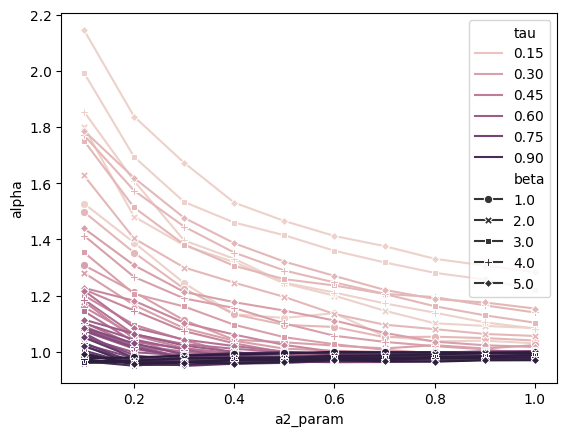

In [ ]:
sns.lineplot(data=df_alpha, x='a2_param', y='alpha', hue='tau', style='beta', markers=True, dashes=False)

In [ ]:
df_alpha

,a2_param,tau,beta,alpha
0,0.9,0.1,2.0,1.092143
1,0.9,0.1,3.0,1.257426
2,0.6,0.8,1.0,0.997469
3,0.6,0.7,5.0,0.962901
4,1.0,0.3,5.0,1.017087
...,...,...,...,...
495,0.9,0.6,4.0,0.974992
496,0.9,0.4,1.0,0.992801
497,1.0,0.9,2.0,0.998703
498,0.5,1.0,1.0,0.994370


In [ ]:
def LEload_data_to_dataframe(directory):
    """
    Scans a directory for CSV files containing matrix data, extracts 
    parameters from filenames, loads each matrix, flattens it, and 
    returns everything in a single pandas DataFrame.

    Args:
        directory (str): The path to the directory containing the CSV files.

    Returns:
        pandas.DataFrame: A DataFrame where each row corresponds to a file,
                          with columns for parameters and the flattened data.
    """
    pattern = re.compile(r'A2_(\d+\.?\d*)_tau_(\d+\.?\d*)_beta_(\d+\.?\d*)\.csv$')
    
    all_files_data = []

    for filename in os.listdir(directory):
        match = pattern.match(filename)
        
        if match:
            a2_val, tau_val, beta_val = match.groups()
            file_path = os.path.join(directory, filename)
            
            # --- This is the key change ---
            # 1. Read the full MxM matrix into a DataFrame
            matrix_df = pd.read_csv(file_path, header=None,delim_whitespace=True)
            
            # 2. Get the underlying NumPy array and flatten it into a 1D array
            flattened_data = matrix_df.values.flatten()
            # -----------------------------
            
            data_row = {
                'a2_param': float(a2_val),
                'tau': float(tau_val),
                'beta': float(beta_val),
                # The 'data' column now holds a 1D NumPy array
                'data': flattened_data
            }
            
            all_files_data.append(data_row)
            
    if not all_files_data:
        print("⚠️ No matching files were found.")
        return pd.DataFrame()
        
    return pd.DataFrame(all_files_data)


In [ ]:
Dir = '../LE/'
LE = LEload_data_to_dataframe(Dir)
df_long = LE.explode('data')

# 2. (Optional but good practice) Ensure the data column is a numeric type
df_long['data'] = pd.to_numeric(df_long['data'])
df_summary = df_long[['a2_param', 'tau', 'beta']].copy()
df_summary = df_long.groupby(['a2_param', 'tau', 'beta'])['data'].mean().reset_index(name='mean_value')


/var/folders/06/3zrj5_vd2_n7v_11httjb1d80000gn/T/ipykernel_85894/2431184.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  matrix_df = pd.read_csv(file_path, header=None,delim_whitespace=True)
/var/folders/06/3zrj5_vd2_n7v_11httjb1d80000gn/T/ipykernel_85894/2431184.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  matrix_df = pd.read_csv(file_path, header=None,delim_whitespace=True)
/var/folders/06/3zrj5_vd2_n7v_11httjb1d80000gn/T/ipykernel_85894/2431184.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  matrix_df = pd.read_csv(file_path, header=None,delim_whitespace=True)
/var/folders/06/3zrj5_vd2_n7v_11httjb1d80000gn/T/ipykernel_85894/2431184.py:27: FutureWarning: The 'delim_whitespace' 

In [ ]:
merged_df = pd.merge(
    df_summary, 
    df_alpha, 
    on=['a2_param', 'tau', 'beta'], 
    how='inner'
)
merged_df

,a2_param,tau,beta,mean_value,alpha
0,0.1,0.1,1.0,0.337799,1.527680
1,0.1,0.1,2.0,0.252993,1.799247
2,0.1,0.1,3.0,0.211175,1.993423
3,0.1,0.1,4.0,0.208662,1.854747
4,0.1,0.1,5.0,0.183126,2.145469
...,...,...,...,...,...
183,1.0,0.3,4.0,0.720804,0.990519
184,1.0,0.3,5.0,0.652428,1.017087
185,1.0,0.4,1.0,0.676214,1.001405
186,1.0,0.4,2.0,0.681857,0.986358


In [ ]:
merged_df['mean_value'].corr(merged_df['alpha'])

np.float64(-0.7766734882908891)

<Axes: xlabel='mean_value', ylabel='alpha'>

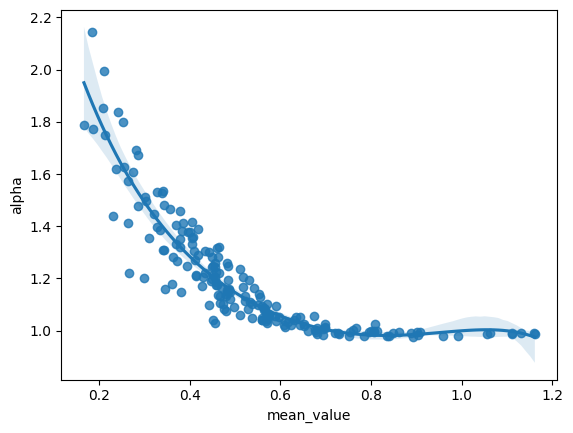

In [ ]:
sns.regplot(data=merged_df, x='mean_value', y='alpha',order=5)

In [ ]:
#sns.lmplot(data=merged_df, x='mean_value', y='alpha', hue='a2_param', height=6)

In [ ]:
merged_df['mean_value'].corr(merged_df['alpha'], method='spearman')

np.float64(-0.9462531627738134)

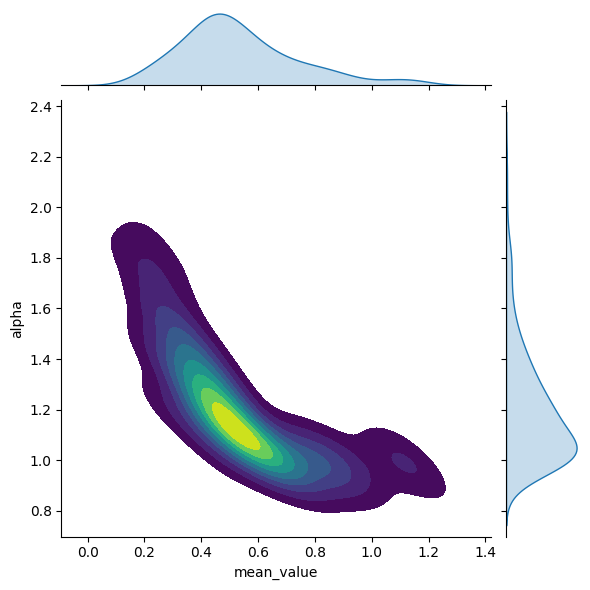

In [ ]:
sns.jointplot(data=merged_df, x='mean_value', y='alpha', kind='kde', fill=True, cmap='viridis')

Fit Parameters: A = 2.662, k = 5.760


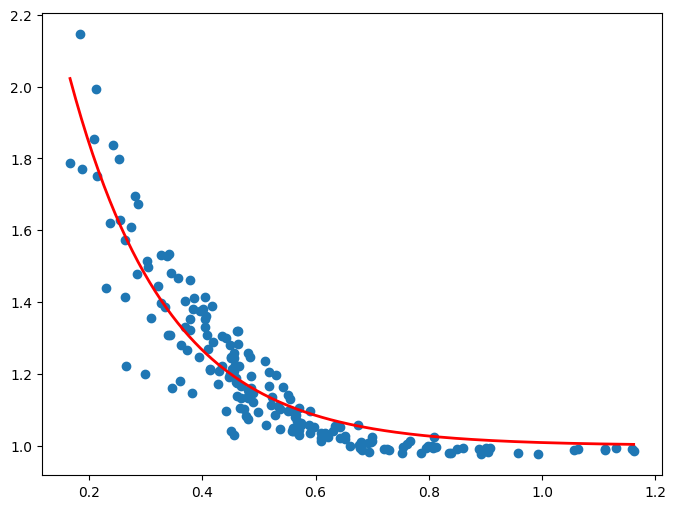

In [ ]:
def exponential_decay(x, A, k):
    """Exponential decay model with a baseline of 1.0."""
    return A * np.exp(-k * x) + 1.0

# 2. Extract your data
x_data = merged_df['mean_value']
y_data = merged_df['alpha']

# 3. Perform the non-linear fit
#    popt will contain the optimized values for [A, k]
popt, pcov = curve_fit(exponential_decay, x_data, y_data)
A_fit, k_fit = popt
print(f"Fit Parameters: A = {A_fit:.3f}, k = {k_fit:.3f}")

# 4. Visualize the new, better fit
plt.figure(figsize=(8, 6))

# Plot the original data points
plt.scatter(x_data, y_data, label='Original Data')

# Generate a smooth line for the fitted curve
x_smooth = np.linspace(x_data.min(), x_data.max(), 200)
y_fit = exponential_decay(x_smooth, A_fit, k_fit)

# Plot the fitted exponential curve
plt.plot(x_smooth, y_fit, color='red', linewidth=2, label='Exponential Fit')


In [ ]:
df_filtres_a2 = df_summary[df_summary['a2_param'] == 0.1]

In [ ]:
a2_merged_df = pd.merge(
    df_filtres_a2, 
    df_alpha, 
    on=['a2_param', 'tau', 'beta'], 
    how='inner'
)
a2_merged_df

,a2_param,tau,beta,mean_value,alpha
0,0.1,0.1,1.0,0.337799,1.527680
1,0.1,0.1,2.0,0.252993,1.799247
2,0.1,0.1,3.0,0.211175,1.993423
3,0.1,0.1,4.0,0.208662,1.854747
4,0.1,0.1,5.0,0.183126,2.145469
5,0.1,0.2,1.0,0.304052,1.497881
6,0.1,0.2,2.0,0.254884,1.627541
7,0.1,0.2,3.0,0.213529,1.751012
8,0.1,0.2,4.0,0.186727,1.770859
9,0.1,0.2,5.0,0.166165,1.786892


<Axes: xlabel='mean_value', ylabel='alpha'>

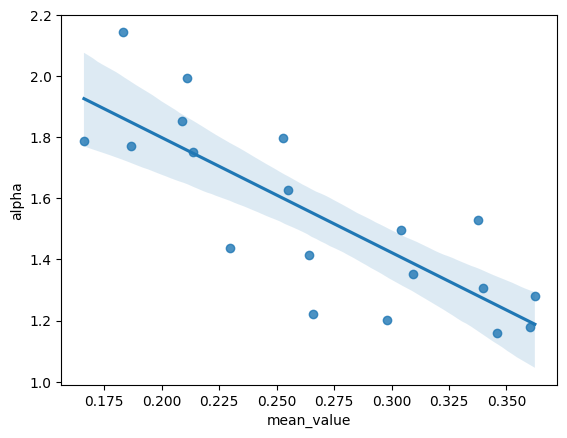

In [ ]:
sns.regplot(data=a2_merged_df, x='mean_value', y='alpha')

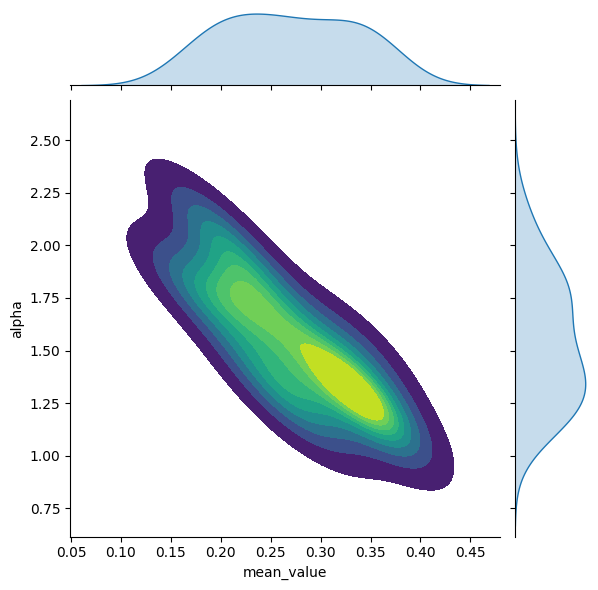

In [ ]:
sns.jointplot(data=a2_merged_df, x='mean_value', y='alpha', kind='kde', fill=True, cmap='viridis')

In [ ]:
a2_merged_df['mean_value'].corr(a2_merged_df['alpha'])

np.float64(-0.8102163348110106)

In [ ]:
a2_merged_df['mean_value'].corr(a2_merged_df['alpha'], method='spearman')

np.float64(-0.8298245614035088)

Fit Parameters: A = 3.291, k = 7.062


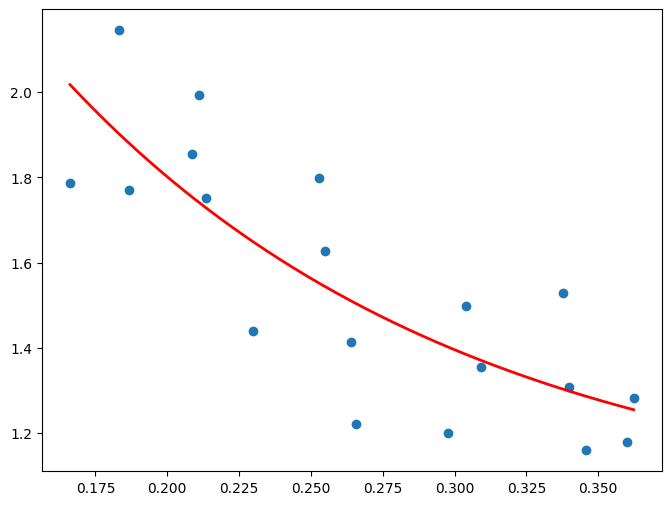

In [ ]:
def exponential_decay(x, A, k):
    """Exponential decay model with a baseline of 1.0."""
    return A * np.exp(-k * x) + 1.0

# 2. Extract your data
x_data = a2_merged_df['mean_value']
y_data = a2_merged_df['alpha']

# 3. Perform the non-linear fit
#    popt will contain the optimized values for [A, k]
popt, pcov = curve_fit(exponential_decay, x_data, y_data)
A_fit, k_fit = popt
print(f"Fit Parameters: A = {A_fit:.3f}, k = {k_fit:.3f}")

# 4. Visualize the new, better fit
plt.figure(figsize=(8, 6))

# Plot the original data points
plt.scatter(x_data, y_data, label='Original Data')

# Generate a smooth line for the fitted curve
x_smooth = np.linspace(x_data.min(), x_data.max(), 200)
y_fit = exponential_decay(x_smooth, A_fit, k_fit)

# Plot the fitted exponential curve
plt.plot(x_smooth, y_fit, color='red', linewidth=2, label='Exponential Fit')